In [1]:
%matplotlib widget
import numpy as np
import json, glob, copy
import os, math
#import pandas as pd
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
from IPython.display import clear_output, display
from datetime import datetime

from alvra_tools.load_data import *
from alvra_tools.channels import *
from alvra_tools.timing_tool import *
from alvra_tools.utils import *
from alvra_tools.YAG_scans import *
from ipyfilechooser import FileChooser

import warnings
warnings.filterwarnings('ignore')

## choose file either with the run number (first cell) or widget (second cell)

In [8]:
pgroup='p20775'
runnumber = 157
print ('run: {:04d}'.format(runnumber))

#############################################################
jsonfile = ''
jsonfile = glob.glob('/sf/alvra/data/{}/raw/*{:04d}*/meta/scan.json'.format(pgroup, runnumber))[0]
titlestring = str( pgroup + ' --- ' +jsonfile.split('/')[-3])
jsonfile

run: 0157


'/sf/alvra/data/p20775/raw/run0157-4TP_MeCN_timescan_XES_pink_2650eV/meta/scan.json'

In [9]:
quantile_band = 0.5

reducedir='../Claudio/Reduced_YAG/'

###################################################################3
from sfdata import SFScanInfo
scan = SFScanInfo(jsonfile)
scan = remove_JF_from_scan(scan)

Delay_mm,Delay_fs,Pump_probe,\
Pump_probe_all,Pump_probe_std,Pump_probe_std_err, Pump_probe_avg = YAG_scan_noTT(scan,quantile_band)

run_name = jsonfile.split('/')[-3]
os.makedirs(reducedir+run_name, exist_ok=True)
save_run_array_YAG(reducedir, run_name, Delay_mm, Delay_fs,
                   Pump_probe, Pump_probe_all, Pump_probe_avg)

pp = Pump_probe[:,0]
err_pp_low = Pump_probe[:,1]
err_pp_high = Pump_probe[:,2]

Processing: run0157-4TP_MeCN_timescan_XES_pink_2650eV
Step 46 of 46: Processing acq0046

--------------------------------------------------------------------------------

SAR-CVME-TIFALL4:EvtSet       2001 / 2001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SLAAR11-LSCP1-FNS:CH0:VAL_GET 2001 / 2001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SLAAR11-LSCP1-FNS:CH2:VAL_GET 2001 / 2001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇

over the whole data set: 2001 / 2001 -> 0% loss
complete channels: 3 / 3 -> 0% incomplete

--------------------------------------------------------------------------------

FEL rep rate is 100.0 Hz
Laser rep rate is 50.0 Hz (delayed or dark)
Pump scheme is 1:1
Loaded 990 pump and 990 unpump shots
Quantile range = 0.25 0.75
Loaded 46 files, size of the arrays = 46
Shape of pump probe data is (46, 990)
------------------------------
Processed 46 out of 46 files


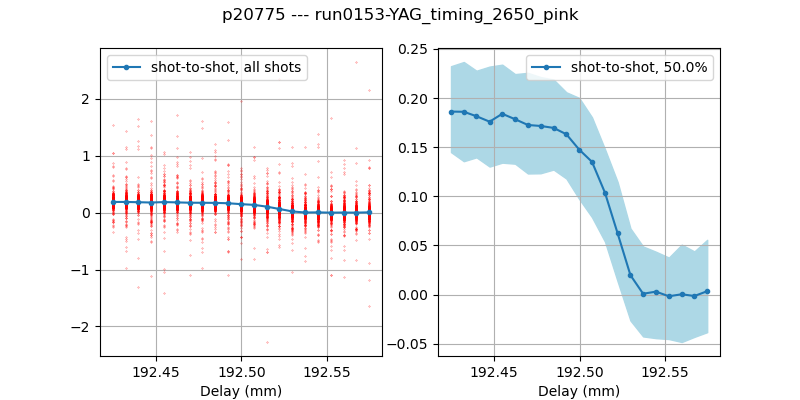

In [4]:
plt.figure(figsize = (8,4))
plt.suptitle(titlestring)

plt.subplot(121)
for i in range(len(Delay_mm)):
    xe = Delay_mm[i]
    ye = Pump_probe_all[i,:]
    plt.plot([xe] * len(ye), ye, 'r.', ms=.5, alpha=0.8)
plt.plot(Delay_mm, pp, label='shot-to-shot, all shots', marker='.')
plt.xlabel("Delay (mm)")
plt.legend(loc="best")
#plt.ylim(-0.04, 0.08)
plt.grid()

plt.subplot(122)
plt.plot(Delay_mm, pp, label='shot-to-shot, {}%'.format(quantile_band*100), marker='.')
plt.fill_between(np.squeeze(Delay_mm), err_pp_low, err_pp_high, color='lightblue')
plt.xlabel("Delay (mm)")
plt.legend(loc="best")
plt.grid()

plt.show()

## Choose fit function

In [5]:
# err function ---------------> [x0, amplitude, width, offset]
# exp_gauss_heaviside --------> [x0, amplitude, width, offset, lifetime]
# conv_exp_gauss_heaviside2 --> [x0, amplitude, width, offset, lifetime, a, b]

fit = Fit(errfunc_fwhm, estimate_errfunc_parameters)
#fit = Fit(conv_exp_gauss_heaviside, estimate_conv_exp_gauss_heaviside_parameters) 
#fit = Fit(conv_exp_gauss_heaviside2, estimate_conv_exp_gauss_heaviside2_parameters)

## Do the fit

In [6]:
fit.estimate(Delay_mm, pp)            # this sets some internal params 
#fit.p0 = better_p0(fit.p0, 0, 210.42) # overwrite some values (index) if needed: 
#fit.p0 = better_p0(fit.p0, 4, 250) # overwrite some values (index) if needed: 

fit.fit(Delay_mm,pp)                  # calculate the fit
pp_fit = fit.eval(Delay_mm)           # evaluate the curve for plotting

t0_mm = fit.popt[0]
width_mm = fit.popt[2]
width_fs = mm2fs(width_mm,0)

print("Position t0 =",np.round(t0_mm,5),"mm")
#print("Width =",np.abs(np.round(width_mm,3))*1000,"um")
#print("Position t0 =",np.round(t0_fs,5),"fs")
print("Width =",np.abs(np.round(width_fs,5)),"fs")

Position t0 = 192.51631 mm
Width = 216.75209 fs


## Plot

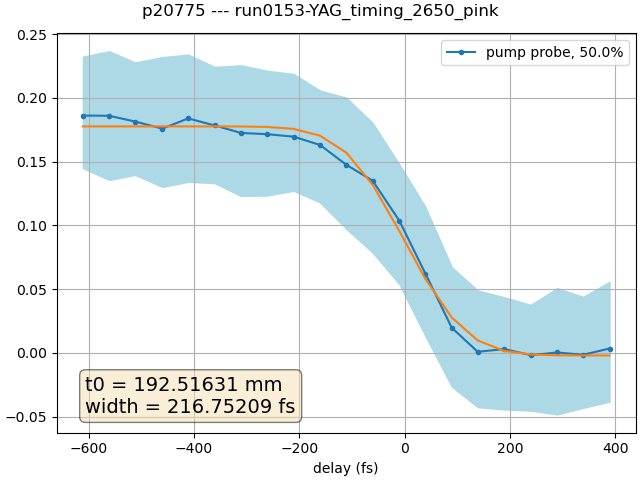

Returned t0 from fit = 192.516312 mm 
Offset to guessed t0 = 192.499701 mm => 110.818 fs


In [7]:
Delay_fs = mm2fs(Delay_mm,t0_mm)

fig, ax = plt.subplots(constrained_layout=True)
#fig, ax = plt.subplots()
plt.suptitle(titlestring)

plt.plot(Delay_fs, pp, label='pump probe, {}%'.format(quantile_band*100),marker='.')
plt.fill_between(Delay_fs, err_pp_low, err_pp_high, color='lightblue')

plt.plot(Delay_fs, pp_fit)

plt.grid()
plt.xlabel("delay (fs)")
plt.legend(loc="best")


boxstyle = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
boxtext = '\n'.join((r't0 = {} mm'.format(np.round(t0_mm, 5)),
                     #r'Deltat0 = {} fs'.format(np.round(t0_fs, 5)),
                   r'width = {} fs'.format(np.abs(np.round(width_fs, decimals = 5)))))
plt.text(0.05, 0.05, boxtext, transform=ax.transAxes, bbox=boxstyle, fontsize=14)

plt.show()
print ('Returned t0 from fit = {:.6f} mm '.format(t0_mm))
print ('Offset to guessed t0 = {:.6f} mm => {:.3f} fs'.format(fit.p0[0], mm2fs(t0_mm, fit.p0[0])))

In [11]:
191.75 - 178.978

12.771999999999991

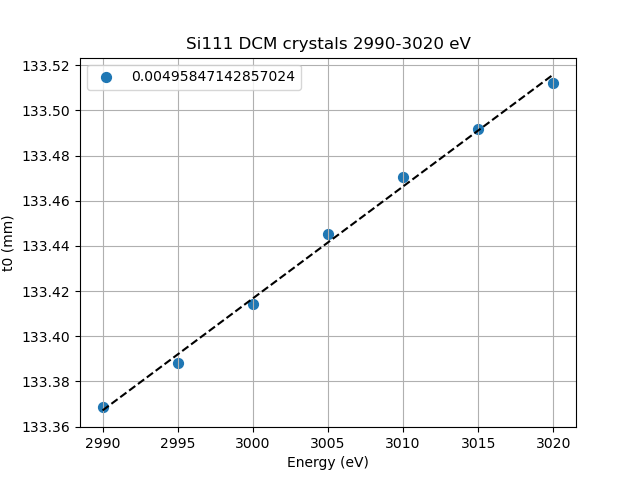

slope (mm/eV) = 0.00495847142857024


In [257]:
energy=np.array([2990, 2995, 3000, 3005, 3010, 3015, 3020 ])
t0= np.array([133.36859, 133.38836, 133.41411, 133.445489, 133.470470, 133.491765,133.512262  ])

#t0_fs= np.array([(t0-113.4531)*2/(3335.64)])
#print(t0_fs)
#plt.figure(figsize = (8,4))
#plt.plot(energy, t0_fs, label='Mono Calibration 2460-2490 eV',marker='o')
#plt.show5



m,b = np.polyfit(energy,t0, 1) 

plt.figure()
plt.title('Si111 DCM crystals 2990-3020 eV')

plt.plot (energy, m*energy + b,  '--', color='black')
plt.scatter(energy, t0, s = 200, marker='.',label = str(m))
plt.legend(loc='best')
plt.xlabel('Energy (eV)')
plt.ylabel('t0 (mm)')
plt.grid()
plt.show()

print('slope (mm/eV) = {}'.format(m))

In [10]:
runlist = np.arange(18, 25, 1)
#runlist = [57,77]
Loaddir = '/sf/alvra/data/p20845/raw/'
##############################################
print ('Will load {} runs: {} from {}'.format(len(runlist), runlist, Loaddir))

Will load 7 runs: [18 19 20 21 22 23 24] from /sf/alvra/data/p20845/raw/


In [11]:
from itertools import chain
datafiles = []
print (runlist)
for run in runlist:
    file = glob.glob(Loaddir + '*{:04d}*/meta/scan.json'.format(run))
    datafiles.append(file)
datafiles = itertools.chain.from_iterable(datafiles)
datafiles = sorted(datafiles, key = os.path.getmtime)
print ('{} files found'.format(len(datafiles)))
datafiles    

[18 19 20 21 22 23 24]
7 files found


['/sf/alvra/data/p20845/raw/run0018-YAG_timing_2990eV/meta/scan.json',
 '/sf/alvra/data/p20845/raw/run0019-YAG_timing_2995eV/meta/scan.json',
 '/sf/alvra/data/p20845/raw/run0020-YAG_timing_3000eV/meta/scan.json',
 '/sf/alvra/data/p20845/raw/run0021-YAG_timing_3005eV/meta/scan.json',
 '/sf/alvra/data/p20845/raw/run0022-YAG_timing_3010eV/meta/scan.json',
 '/sf/alvra/data/p20845/raw/run0023-YAG_timing_3015eV/meta/scan.json',
 '/sf/alvra/data/p20845/raw/run0024-YAG_timing_3020eV/meta/scan.json']

# Loop over several runs

In [12]:
quantile_band = 0.5

Timezero_start = 133.36859

########################################################################
from sfdata import SFScanInfo

t0_fs_scan =[]
width_fs_scan = []

for json_file in datafiles:
    print (json_file)
    scan = SFScanInfo(json_file)
    scan = remove_JF_from_scan(scan)
    
    Delay_mm,Delay_fs,Pump_probe,_,_,_,_ = YAG_scan_noTT(scan,quantile_band)
        
    pp = Pump_probe[:,0]
    
    fit = Fit(errfunc_fwhm, estimate_errfunc_parameters)
    # fit = Fit(conv_exp_gauss_heaviside, estimate_conv_exp_gauss_heaviside_parameters) 
    # fit = Fit(conv_exp_gauss_heaviside2, estimate_conv_exp_gauss_heaviside2_parameters)
    
    fit.estimate(Delay_mm, pp)      # this sets some internal params 
           
    #fit.p0 = better_p0(fit.p0, 0, Timezero_start)  # overwrite some values if needed

    fit.fit(Delay_mm,pp)            # calculate the fit
    pp_fit = fit.eval(Delay_mm)     # evaluate the curve for plotting
    
    t0_mm = fit.popt[0]
    width_mm = fit.popt[2]    
    
    t0_fs_scan.append(mm2fs(t0_mm,Timezero_start))
    width_fs_scan.append(mm2fs(width_mm,0))


Processing: run0024-YAG_timing_3020eV
Step 31 of 31: Processing acq0031

--------------------------------------------------------------------------------

SAR-CVME-TIFALL4:EvtSet       501 / 501 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SLAAR11-LSCP1-FNS:CH0:VAL_GET 501 / 501 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SLAAR11-LSCP1-FNS:CH2:VAL_GET 501 / 501 -> 0% loss ▇▇▇▇▇▇▇▇▇▇

over the whole data set: 501 / 501 -> 0% loss
complete channels: 3 / 3 -> 0% incomplete

--------------------------------------------------------------------------------

FEL rep rate is 100.0 Hz
Laser rep rate is 50.0 Hz (delayed or dark)
Pump scheme is 1:1
Loaded 250 pump and 250 unpump shots
Quantile range = 0.25 0.75
Loaded 31 files, size of the arrays = 31
Shape of pump probe data is (31, 250)


In [13]:
Energy_eV = np.arange(2990, 3025, 5)
Energy_eV

array([2990, 2995, 3000, 3005, 3010, 3015, 3020])

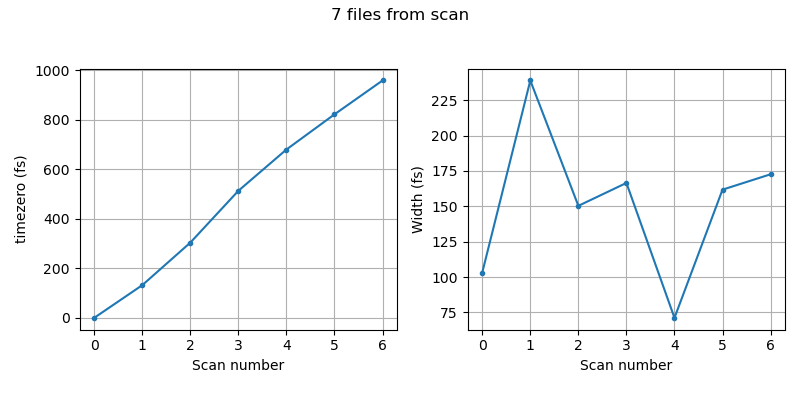

In [15]:
plt.figure(figsize = (8,4))
plt.suptitle ('{} files from {}'.format(len(datafiles), json_file.split('/')[-1].split('.')[0]))

plt.subplot(121)
plt.plot(t0_fs_scan, marker='.')
plt.xlabel('Scan number')
plt.ylabel('timezero (fs)')
plt.grid()

plt.subplot(122)
plt.plot(width_fs_scan, marker='.')
plt.xlabel("Scan number")
plt.ylabel('Width (fs)')
plt.grid()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

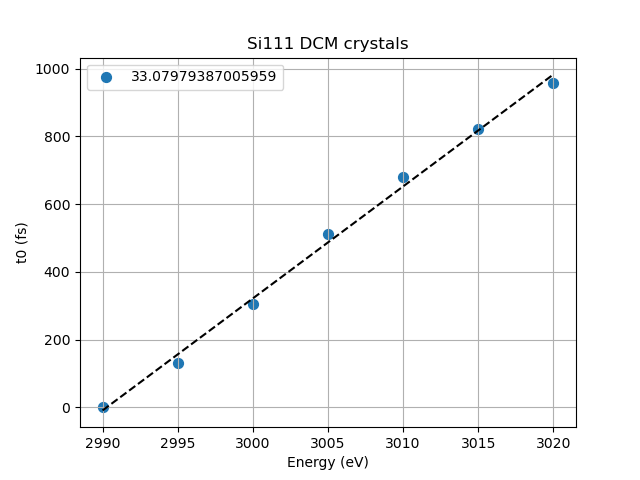

slope (fs/eV) = 33.07979387005959


In [16]:
m,b = np.polyfit(Energy_eV,t0_fs_scan, 1) 

plt.figure()
plt.title('Si111 DCM crystals')

plt.plot (Energy_eV, m*Energy_eV + b,  '--', color='black')
plt.scatter(Energy_eV, t0_fs_scan, s = 200, marker='.',label = str(m))
plt.legend(loc='best')
plt.xlabel('Energy (eV)')
plt.ylabel('t0 (fs)')
plt.grid()
plt.show()

print('slope (fs/eV) = {}'.format(m))

In [55]:
890000-884000

6000

## 2D scan for mono calibration

In [53]:
pgroup='p20845'
runnumber = 25
print ('run: {:04d}'.format(runnumber))

#############################################################
jsonfile = ''
jsonfile = glob.glob('/sf/alvra/data/{}/raw/*{:04d}*/meta/scan.json'.format(pgroup, runnumber))[0]
jsonfile

run: 0025


'/sf/alvra/data/p20845/raw/run0025-mono_calibration_2810-3020/meta/scan.json'

In [54]:
quantile = 0.5

channel_list_pp = [channel_Events, channel_LaserDiode, channel_Laser_refDiode]
channel_list_all = channel_list_pp


###################################################################3
from sfdata import SFScanInfo
scan = SFScanInfo(jsonfile)
scan = remove_JF_from_scan(scan)

Delay_mm = np.asarray(scan.readbacks[:,1])
Energy = np.asarray(scan.readbacks[:,0])
Delay_fs = mm2fs(Delay_mm,0)

Pump_probe_all = []
Pump_probe = []
Pump_probe_avg =[]

for i, step in enumerate(scan):
    check_files_and_data(step)
    clear_output(wait=True)
    filename = scan.files[i][0].split('/')[-1].split('.')[0]
    print ('Processing: {}'.format(scan.fname.split('/')[-3]))
    print ('Step {} of {}: Processing {}'.format(i+1, len(scan.files), filename))
    resultsPP, results_FEL, pids_pump, pids_unpump = load_data_compact_pump_probe(channel_list_pp, channel_list_all, step)

    Laser_pump = resultsPP[channel_LaserDiode].pump
    Laser_ref_pump = resultsPP[channel_Laser_refDiode].pump
    Laser_unpump = resultsPP[channel_LaserDiode].unpump
    Laser_ref_unpump = resultsPP[channel_Laser_refDiode].unpump

    Laser_diff = -np.log10((Laser_pump) / (Laser_unpump))

    Pump_probe_all.append(Laser_diff)
    df_pump_probe = pd.DataFrame(Laser_diff)
    Pump_probe.append(np.nanquantile(df_pump_probe, [0.5, 0.5 - quantile/2, 0.5 + quantile/2]))

    Pump = np.median(Laser_pump)
    Unpump = np.median(Laser_unpump)
    Pump_probe_avg.append(-np.log10((Pump) / (Unpump)))
    
run_name = jsonfile.split('/')[-3]
os.makedirs(reducedir+run_name, exist_ok=True)



Processing: run0025-mono_calibration_2810-3020
Step 4 of 5332: Processing acq0004

--------------------------------------------------------------------------------

SAR-CVME-TIFALL4:EvtSet       501 / 501 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SLAAR11-LSCP1-FNS:CH0:VAL_GET 501 / 501 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SLAAR11-LSCP1-FNS:CH2:VAL_GET 501 / 501 -> 0% loss ▇▇▇▇▇▇▇▇▇▇

over the whole data set: 501 / 501 -> 0% loss
complete channels: 3 / 3 -> 0% incomplete

--------------------------------------------------------------------------------

FEL rep rate is 100.0 Hz
Laser rep rate is 50.0 Hz (delayed or dark)
Pump scheme is 1:1
Loaded 250 pump and 250 unpump shots


KeyboardInterrupt: 

In [83]:
run_array = {}
run_array[run_name.split('-')[0]] = {"name": run_name,
                                "Delay_mm": Delay_mm,
                                "Delay_fs": Delay_fs,
                                "Pump_probe": Pump_probe,
                                "Pump_probe_all": Pump_probe_all,
                                "Pump_probe_avg": Pump_probe_avg}

np.save(reducedir+run_name+'/run_array', run_array)

In [84]:
pp = Pump_probe[:,0]
energy_axis = np.reshape(Energy, (43,124))
delay_axis = np.reshape(Delay_fs, (43, 124))
pp_2D = np.reshape(pp, (43, 124))

In [92]:
t0_mono=[]
width_mono=[]
for index in range(len(pp_2D)):
    fit.estimate(delay_axis[0,:], pp_2D[index,:])            # this sets some internal params 
    fit.fit(delay_axis[0,:],pp_2D[index,:])                  # calculate the fit
    pp_fit = fit.eval(delay_axis[0,:])           # evaluate the curve for plotting

    t0_mono.append(fit.popt[0])
    width_mono.append(fit.popt[2])

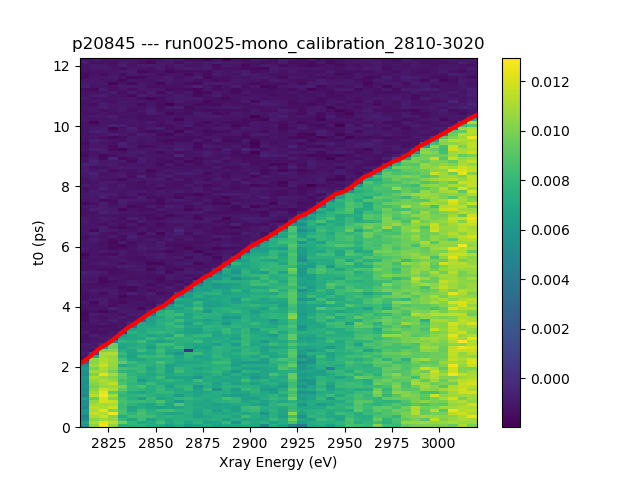

In [99]:
plt.figure()
plt.title(pgroup+ ' --- '+ jsonfile.split('/')[-3])
plt.pcolormesh(energy_axis[:,0],(delay_axis[0,:]-delay_axis[0,0])/1000, pp_2D.T)
plt.plot(energy_axis[:,0], (t0_mono-delay_axis[0,0])/1000, color ='r', linewidth=3)
plt.xlabel('Xray Energy (eV)')
plt.ylabel('t0 (ps)')
plt.colorbar()
plt.show()

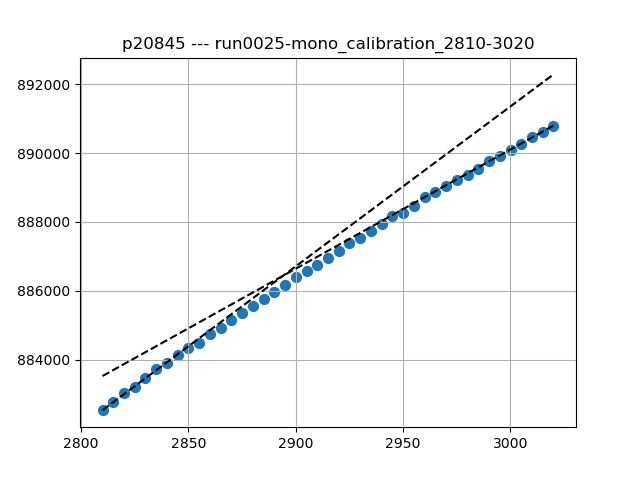

Cl K edge: slope (fs/eV) = 34.618914955309634
Rh L edge: slope (fs/eV) = 46.42981830280732


In [111]:
m_Cl,b_Cl = np.polyfit(energy_axis[-7:,0],t0_mono[-7:], 1) 
m_Rh,b_Rh = np.polyfit(energy_axis[:7,0],t0_mono[:7], 1) 

plt.figure()
plt.title(pgroup+ ' --- '+ jsonfile.split('/')[-3])
plt.plot (energy_axis[:,0], m_Cl*energy_axis[:,0] + b_Cl,  '--', color='black')
plt.plot (energy_axis[:,0], m_Rh*energy_axis[:,0] + b_Rh,  '--', color='black')
plt.scatter(energy_axis[:,0], t0_mono, s = 200, marker='.',label = str(m))
plt.grid()
plt.show()
print('Cl K edge: slope (fs/eV) = {}'.format(m_Cl))
print('Rh L edge: slope (fs/eV) = {}'.format(m_Rh))

In [ ]:
quantile_laser = 0.68

Timezero_loop = 189.8264819165063

channel_pressure = 'SLAAR11-LTIM01-EVR0:DUMMY_PV8_NBS'

channel_list_pp = [channel_Events, channel_LaserDiode, channel_Laser_refDiode, channel_pressure]
channel_list_all = channel_list_pp + [channel_delay_harm]

########################################################################
from sfdata import SFScanInfo

width_fs_loop = []
t0_fs_loop =[]
timestamp = []
scan_number = []

skipped_runs = []
Pressure_scan = []

for json_file in patch:
    print (json_file)
    scan_number.append(json_file.split('/')[-1].split('_')[-1].split('.')[0])
    scan = SFScanInfo(json_file)
    Delay_fs = scan.readbacks - Timezero_loop *2/(299792458*1e3*1e-15)
    Delay_mm = scan.readbacks /2*(299792458*1e3*1e-15)
    
    Pump_probe_all = []
    Pump_probe = []
    Pump_probe_avg =[]
    Pump_probe_std = []
    Pump_probe_std_err = []
    Pressure_run = []
    
    with h5py.File(scan.files[0][1], 'r') as fn:
        timestamp.append(fn[channel_Events]['timestamp'][()])
    
    for i, step in enumerate(scan):
        check_files_and_data(step)
        clear_output(wait=True)
        print ('Step {} of {}: Processing {}'.format(i+1, len(scan.files), scan.files[i]))
        
        
        try:
            resultsPP, results_FEL, pids_pump, pids_unpump = load_data_compact_FEL_pump(channel_list_pp, channel_list_all, step)

            Laser_pump = resultsPP[channel_LaserDiode].pump
            Laser_ref_pump = resultsPP[channel_Laser_refDiode].pump
            Laser_unpump = resultsPP[channel_LaserDiode].unpump
            Laser_ref_unpump = resultsPP[channel_Laser_refDiode].unpump
            
            Pressure_run.append(np.mean(resultsPP[channel_pressure].pump))

            #Izero_FEL = results_FEL[channel_Izero117]

            #Laser_diff = -np.log10((Laser_pump/Laser_ref_pump) / (Laser_unpump/ Laser_ref_unpump)) #/ (Izero_FEL)
            Laser_diff = -np.log10((Laser_pump) / (Laser_unpump))
            #Laser_diff = ((Laser_pump) / (Laser_unpump))

            Pump_probe_all.append(Laser_diff)
            df_pump_probe = pd.DataFrame(Laser_diff)
            Pump_probe.append(np.nanquantile(df_pump_probe, [0.5, 0.5 - quantile_laser/2, 0.5 + quantile_laser/2]))

            Pump_probe_std.append(np.nanmean(Laser_diff))
            Pump_probe_std_err.append(np.nanstd(Laser_diff))#/np.sqrt(len(Laser_diff)))

            Pump = np.median(Laser_pump)
            Unpump = np.median(Laser_unpump)
            Pump_probe_avg.append(-np.log10((Pump) / (Unpump)))  
        except:
            Delay_mm = np.delete(Delay_mm, i)
            Delay_fs = np.delete(Delay_fs, i)
            skipped_runs.append(scan.files[i])
    
    Pressure_scan.append(np.mean(Pressure_run))
    
    Pump_probe_all = np.asarray(Pump_probe_all)
    Pump_probe = np.asarray(Pump_probe)
    Pump_probe_avg = np.asarray(Pump_probe_avg)
    Pump_probe_std = np.asarray(Pump_probe_std)
    Pump_probe_std_err = np.asarray(Pump_probe_std_err)
    
    minlen = min(len(i) for i in Pump_probe_all)
    def cut(arr, minlen):
        return np.array([i[:minlen] for i in arr])
    Pump_probe_all = cut(Pump_probe_all, minlen)


    Delay_mm = np.asarray(Delay_mm)
    Delay_fs = np.asarray(Delay_fs)
    
    pp_loop = Pump_probe[:,0]
    Delay_fs_toFit_loop = np.copy(Delay_fs)#(Delay_mm - Timezero_loop)*2/(3e8*1e3*1e-15) 
    
    index = ~(np.isnan(Delay_fs_toFit_loop) | np.isnan(pp_loop))
#     parameters_fs_loop,extras = curve_fit(conv_exp_gauss_heaviside, Delay_fs_toFit_loop, pp_loop, p0 = [0, 0.02, 100, 0, 700])
    parameters_fs_loop,extras = curve_fit(errfunc_fwhm, Delay_fs_toFit_loop, pp_loop, p0 = [0, 0.08, 200, 0])
    #exp_gauss_heaviside:  x0, amplitude, fwhm, offset, lifetime
    t0_fs_loop.append(parameters_fs_loop[0])
    width_fs_loop.append(np.abs(parameters_fs_loop[2]))
    
scan_number = np.asarray(scan_number)    

In [19]:
offset_space = 19.93699999999876     # this is in um

offset_time = 2*(offset_space * 1e-6)/3e8/1e-15            #factor of 2 because of the delay stage, results in fs
print ("An offset of",offset_space,"um corresponds to an offset of",np.round(offset_time,4),"fs")

An offset of 19.93699999999876 um corresponds to an offset of 132.9133 fs


In [90]:
offset_time = 500000      # this is in fs

offset_space = 3e8 * (offset_time * 1e-15)/2/1e-6          #factor of 2 because of the delay stage, results in um
print ("An offset of",offset_time,"fs corresponds to an offset of",np.round(offset_space,4),"um")

An offset of 500000 fs corresponds to an offset of 75000.0 um


In [34]:
7.5296 - 7.5016

0.02800000000000047

In [112]:
133.445489 - 132.453714

0.9917750000000183